### Introduction 
This notebook is created based on this research paper [**PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts**](https://arxiv.org/pdf/1710.06071.pdf)<br>

The summary of this reseach paper is that, it converts medical research paper **Abstract's** each sentence to a category (background, objective, methods, results, conclusions).

### Getting the data
Good thing is that data is publicly available.

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 13.79 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [2]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls /kaggle/working/pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


`dev.txt` is validation set <br>
`test.txt` is test set and<br>
`train.txt` is train set

In [4]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

### Preprocessing data

In [6]:
def read_lines(filename):
    with open(filename) as file:
        return file.readlines()

In [7]:
filenames[0]

'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt'

In [8]:
train_file = read_lines(filename=filenames[1])
train_file[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
def preprocess_text(filename):
    
    input_lines = read_lines(filename)

    abstract_lines = ""
    abstracts = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_lines = ""

        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                line_split = abstract_line.split("\t")
                line_data["target"] = line_split[0]
                line_data["text"] = line_split[1].lower()
                line_data["line_number"] = abstract_line_number + 1
                line_data["total_lines"] = len(abstract_line_split)
                abstracts.append(line_data)
        else:
            abstract_lines += line
    
    return abstracts

In [10]:
abstracts = preprocess_text(filename=filenames[0])
abstracts[:10]

[{'target': 'BACKGROUND',
  'text': 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'line_number': 1,
  'total_lines': 10},
 {'target': 'BACKGROUND',
  'text': 'it is not clear whether these patients would benefit from antifungal treatment .',
  'line_number': 2,
  'total_lines': 10},
 {'target': 'OBJECTIVE',
  'text': 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
  'line_number': 3,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
  'line_number': 4,
  'total_lines': 10},
 {'t

In [11]:
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

### Visualizing Data

In [12]:
train_samples = preprocess_text(filename=data_dir + "train.txt")
dev_samples = preprocess_text(filename=filenames[1])
test_samples = preprocess_text(filename=filenames[2])

In [13]:
import pandas as pd

In [14]:
train_df = pd.DataFrame(train_samples)
dev_df = pd.DataFrame(dev_samples)
test_df = pd.DataFrame(test_samples)

In [15]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,1,12
1,METHODS,a total of @ patients with primary knee oa wer...,2,12
2,METHODS,outcome measures included pain reduction and i...,3,12
3,METHODS,pain was assessed using the visual analog pain...,4,12
4,METHODS,secondary outcome measures included the wester...,5,12
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,8,12
180036,RESULTS,"for pav , a significantly greater percentage o...",9,12
180037,RESULTS,both strategies had acceptable side effect pro...,10,12
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",11,12


In [16]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

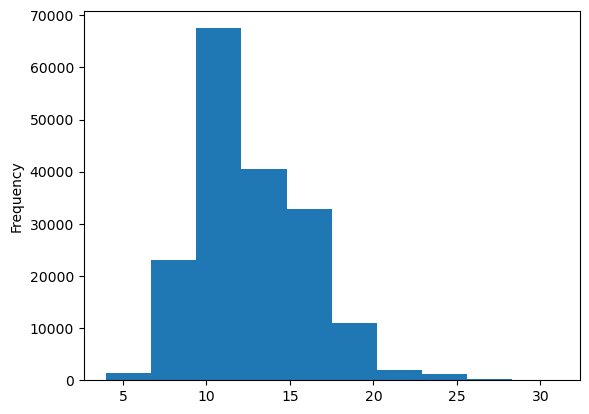

In [17]:
train_df["total_lines"].plot.hist();

In [18]:
len(train_df["text"]), len(dev_df["text"]), len(test_df["text"])

(180040, 180040, 30135)

### Splitting Data

In [19]:
train_sentences = train_df["text"]
val_sentences = dev_df["text"]
test_sentences = test_df["text"]

In [20]:
train_target = train_df["target"]
val_target = dev_df["target"]
test_target = test_df["target"]

### `OneHotEncoder`

In [21]:
from sklearn.preprocessing import OneHotEncoder

In [22]:
one_hot_encoder = OneHotEncoder(sparse=False)
train_target_hot_encoder = one_hot_encoder.fit_transform(train_target.to_numpy().reshape(-1,1)) 
val_target_hot_encoder = one_hot_encoder.fit_transform(val_target.to_numpy().reshape(-1,1)) 
test_target_hot_encoder = one_hot_encoder.fit_transform(test_target.to_numpy().reshape(-1,1)) 

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
train_target_hot_encoder

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### `LabelEncoder`

In [24]:
from sklearn.preprocessing import LabelEncoder

In [25]:
label_encoder = LabelEncoder()
train_target_label_encoder = label_encoder.fit_transform(train_target.to_numpy().reshape(-1,1))
val_target_label_encoder = label_encoder.fit_transform(val_target.to_numpy().reshape(-1,1))
test_target_label_encoder = label_encoder.fit_transform(test_target.to_numpy().reshape(-1,1))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
len(label_encoder.classes_), label_encoder.classes_

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### `model_0`: Baseline

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [28]:
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("multinomialNB", MultinomialNB())
])

In [29]:
model_0.fit(train_sentences, train_target_label_encoder)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('multinomialNB', MultinomialNB())])

### Evaluation function

In [30]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [31]:
def calculate_results(y_true, y_pred):
    """
    returns a dictionary of accuracy_score, precission, recall and f1_score
    """
    precission, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    acc_score = accuracy_score(y_true, y_pred) * 100
    
    results = {
        "accuracy_score": acc_score,
        "precission": precission,
        "recall": recall,
        "f1_score": f1_score
    }
    return results

In [32]:
baseline_results = calculate_results(val_target_label_encoder, model_0.predict(val_sentences))
baseline_results

{'accuracy_score': 75.16829593423684,
 'precission': 0.7556121877731266,
 'recall': 0.7516829593423684,
 'f1_score': 0.734085177322999}

### Text vectorization (tokenization)

In [33]:
from tensorflow.keras.layers import TextVectorization

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [34]:
import numpy as np

In [35]:
sentences_word_size = [len(sentence.split()) for sentence in train_sentences]
sentence_length = np.percentile(sentences_word_size, 95) # gives the size of sentence length for 95% sentence
sentence_length

55.0

In [36]:
max_tokens = 68000 # in the paper, for 20k dataset maximum vocabulary is 68k

In [37]:
text_vectorization = TextVectorization(max_tokens=max_tokens,
                                      output_sequence_length=int(sentence_length))

In [38]:
text_vectorization.adapt(train_sentences)

In [39]:
import random

In [40]:
random_sentence = random.choice(train_sentences)
print(random_sentence)
print(f"After tokenization {text_vectorization(random_sentence)}")

@ patients were randomly divided into two groups : ga ( n = @ ) received spinal anesthesia and gb ( n = @ ) received spinal anesthesia and fnb .
After tokenization [  12    9   92  471  143   51   24 1986   40   80  841  435    3 3138
   40   80  841  435    3 6660    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [41]:
print(f"5 most common words: {text_vectorization.get_vocabulary()[:5]}")
print(f"5 least common words: {text_vectorization.get_vocabulary()[-5:]}")

5 most common words: ['', '[UNK]', 'the', 'and', 'of']
5 least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Embedding

In [42]:
from tensorflow.keras.layers import Embedding

In [43]:
embedding = Embedding(input_dim=max_tokens, # 68000 set earlier from paper
                     output_dim=128, # multiple of 8 can be 64, 128, 256, 512
                     mask_zero=True) # increase the computaional power for 0 

In [44]:
random_sentence = random.choice(train_sentences)
print(f"Sentence before embedding: {random_sentence}")
embedding(text_vectorization([random_sentence]))

Sentence before embedding: correlations and linear mixed models were performed to determine cross-sectional and longitudinal associations between baseline amyloid @-@ ( a@ ) , total tau ( t-tau ) , and phosphorylated tau ( p-tau ) in cerebrospinal fluid ( csf ) and measures of memory and executive function .


<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.03137168,  0.04428658, -0.04925226, ..., -0.04049166,
          0.01492042, -0.00657576],
        [ 0.00064989, -0.03485844, -0.00044135, ..., -0.00794953,
         -0.04615542,  0.04437445],
        [-0.0192336 ,  0.01336339, -0.01897227, ..., -0.01948812,
          0.04674837,  0.01367674],
        ...,
        [ 0.00320479,  0.02342949,  0.04014042, ...,  0.01334003,
          0.00605323, -0.04945118],
        [ 0.00320479,  0.02342949,  0.04014042, ...,  0.01334003,
          0.00605323, -0.04945118],
        [ 0.00320479,  0.02342949,  0.04014042, ...,  0.01334003,
          0.00605323, -0.04945118]]], dtype=float32)>

**Note:** If we see the shape of the embedded sentence, we will notice it is (1, 55, 128)
which means from every sentence we will take 55 words and each word will be represented with 128 shape matrix.

### Creating Datasets

In [45]:
import tensorflow as tf

In [46]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_target_hot_encoder))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_target_hot_encoder))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_target_hot_encoder))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [47]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### `model_1`: Conv1D

In [48]:
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorization(inputs)
token_embeddings = embedding(text_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_conv1D")

In [49]:
model_1.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                

In [50]:
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [51]:
history_conv1D = model_1.fit(train_dataset,
                             steps_per_epoch=int(0.1 * len(train_dataset)),
                             epochs=3,
                             validation_data=val_dataset,
                             validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 42s 61ms/step - loss: 0.8383 - accuracy: 0.6807 - val_loss: 0.4611 - val_accuracy: 0.8438
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 0.5808 - accuracy: 0.7859 - val_loss: 0.4541 - val_accuracy: 0.8402
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.5449 - accuracy: 0.8001 - val_loss: 0.4563 - val_accuracy: 0.8392


In [52]:
model_1.evaluate(val_dataset)

5627/5627 [==============================] - 18s 3ms/step - loss: 0.4893 - accuracy: 0.8245


[0.48930665850639343, 0.8244889974594116]

In [53]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

NameError: name 'model_1_pred_probs' is not defined

In [ ]:
model_1_results = calculate_results(y_true=val_target_label_encoder,
                                    y_pred=model_1_preds)
model_1_results

### `model_2`: Transfer learning

In [ ]:
import tensorflow_hub as hub

**Note:** In the paper `GloVe` model was used as pretrained model, but we will use `universal-sentence-encoder`(USN)

In [ ]:
universal_sentence_encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                            trainable=False,
                                            name="universal_sentence_encoder")

In [ ]:
random_sentence = random.choice(train_sentences)
print(random_sentence)
print(f"After USN:\n{universal_sentence_encoder([random_sentence])[0][:30]}")

In [ ]:
inputs = tf.keras.Input(shape=[], dtype=tf.string)
x = universal_sentence_encoder(inputs)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USN")

In [ ]:
model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [ ]:
model_2.summary()

In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=round(0.1*len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=round(0.1*len(train_dataset)))

In [ ]:
model_2.evaluate(val_dataset)

In [ ]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

In [ ]:
model_2_pred = tf.argmax(model_2_pred_probs, axis=1)
model_2_pred

In [ ]:
model_2_results = calculate_results(y_true=val_target_label_encoder,
                                    y_pred=model_2_pred)
model_2_results

### Character vectorization

In [65]:
def split_char(sentence):
    return " ".join(list(sentence))

In [67]:
split_char(random_sentence)

'c o r r e l a t i o n s   a n d   l i n e a r   m i x e d   m o d e l s   w e r e   p e r f o r m e d   t o   d e t e r m i n e   c r o s s - s e c t i o n a l   a n d   l o n g i t u d i n a l   a s s o c i a t i o n s   b e t w e e n   b a s e l i n e   a m y l o i d   @ - @   (   a @   )   ,   t o t a l   t a u   (   t - t a u   )   ,   a n d   p h o s p h o r y l a t e d   t a u   (   p - t a u   )   i n   c e r e b r o s p i n a l   f l u i d   (   c s f   )   a n d   m e a s u r e s   o f   m e m o r y   a n d   e x e c u t i v e   f u n c t i o n   .'

In [70]:
train_chars = [split_char(sentence) for sentence in train_sentences]
val_chars = [split_char(sentence) for sentence in val_sentences]
test_chars = [split_char(sentence) for sentence in test_sentences]

In [71]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [80]:
train_chars_length = [len(sentence) for sentence in train_sentences]
output_seq_length = np.percentile(train_chars_length, 95)

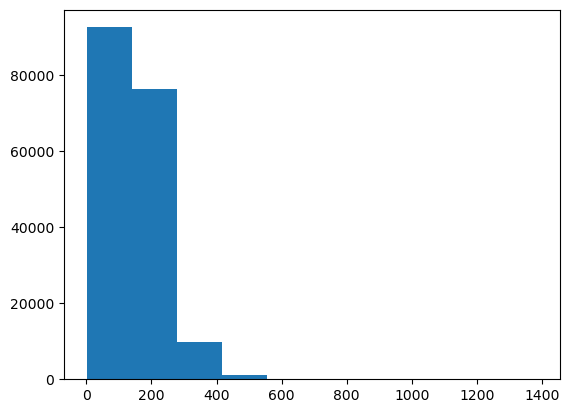

In [75]:
import matplotlib.pyplot as plt
plt.hist(train_chars_length);

In [76]:
import string

In [77]:
alphabet = string.ascii_lowercase + string.punctuation 
alphabet

'abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

**Note:** In our dataset(`PubMed` digits replaced with @) there is no numbers, so we omitted `string.digits` but,<br>
if we have used `PubMed` (digits not replaced with @) we would have included `string.digits`

In [78]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # extra 2 is for space and OOV token

In [82]:
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS, 
                                    output_sequence_length=int(output_seq_length)) # 95

In [83]:
char_vectorizer.adapt(train_chars)

In [91]:
random_train_chars = random.choice(train_chars)
print(f"Sentence in character level:")
print(f"{random_train_chars}")
print(f"After vectorization:")
char_vectorizer(random_train_chars)

Sentence in character level:
d i f f e r e n c e s   b e t w e e n   t r e a t m e n t   g r o u p s   a t   e n d   o f   t h e r a p y   (   @   @   s c o r e   p o i n t s   ;   p   <   @   )   a n d   p a t i e n t - a s s e s s e d   q u a l i t y   o f   l i f e   (   p   =   @   )   w e r e   s t a t i s t i c a l l y   s i g n i f i c a n t   i n   f a v o r   o f   b n o   @   .
After vectorization:


<tf.Tensor: shape=(290,), dtype=int64, numpy=
array([10,  4, 17, 17,  2,  8,  2,  6, 11,  2,  9, 22,  2,  3, 20,  2,  2,
        6,  3,  8,  2,  5,  3, 15,  2,  6,  3, 18,  8,  7, 16, 14,  9,  5,
        3,  2,  6, 10,  7, 17,  3, 13,  2,  8,  5, 14, 19,  9, 11,  7,  8,
        2, 14,  7,  4,  6,  3,  9, 14,  5,  6, 10, 14,  5,  3,  4,  2,  6,
        3,  5,  9,  9,  2,  9,  9,  2, 10, 26, 16,  5, 12,  4,  3, 19,  7,
       17, 12,  4, 17,  2, 14, 20,  2,  8,  2,  9,  3,  5,  3,  4,  9,  3,
        4, 11,  5, 12, 12, 19,  9,  4, 18,  6,  4, 17,  4, 11,  5,  6,  3,
        4,  6, 17,  5, 21,  7,  8,  7, 17, 22,  6,  7,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [92]:
print(f"5 most common words: {char_vectorizer.get_vocabulary()[:5]}")
print(f"5 least common words: {char_vectorizer.get_vocabulary()[-5:]}")

5 most common words: ['', '[UNK]', 'e', 't', 'i']
5 least common words: ['k', 'x', 'z', 'q', 'j']
